In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Diasumsikan file berada di direktori yang sama
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')

# Gabungkan train dan test untuk preprocessing yang konsisten
train_labels = app_train['TARGET']
app_train['is_train'] = True
app_test['is_train'] = False
app_test['TARGET'] = np.nan

df = pd.concat([app_train, app_test], axis=0, ignore_index=True)

In [2]:
# Membuat fitur rasio yang umum dalam analisis kredit
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

print("Fitur rasio baru telah dibuat.")

Fitur rasio baru telah dibuat.


In [3]:
# 1. Identifikasi kolom berdasarkan tipe datanya
# Kolom numerik akan dihitung mean, max, min, sum
num_cols = bureau.select_dtypes(include=[np.number]).columns.tolist()
# Kolom kategorikal akan dihitung jumlahnya (count) atau di-encode dulu
cat_cols = bureau.select_dtypes(include=['object']).columns.tolist()

# Pastikan SK_ID_CURR tidak ikut di-aggregate sebagai data numerik, tapi sebagai key
if 'SK_ID_CURR' in num_cols: num_cols.remove('SK_ID_CURR')
if 'SK_ID_BUREAU' in num_cols: num_cols.remove('SK_ID_BUREAU')

# 2. Lakukan agregasi secara terpisah agar tidak error
# Agregasi untuk Numerik
bureau_num_agg = bureau.groupby('SK_ID_CURR')[num_cols].agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_num_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in bureau_num_agg.columns.values]

# Agregasi untuk Kategorikal (One-Hot Encoding dulu baru di-mean untuk dapat persentase)
bureau_cat = pd.get_dummies(bureau[['SK_ID_CURR'] + cat_cols])
bureau_cat_agg = bureau_cat.groupby('SK_ID_CURR').agg(['mean']).reset_index()
bureau_cat_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in bureau_cat_agg.columns.values]

# 3. Gabungkan hasil agregasi numerik dan kategorikal
bureau_final_agg = bureau_num_agg.merge(bureau_cat_agg, on='SK_ID_CURR', how='left')

# 4. Sekarang baru digabungkan ke dataframe utama (app_train/df)
df = df.merge(bureau_final_agg, on='SK_ID_CURR', how='left')

print("Agregasi berhasil! Data teks sudah diubah menjadi rasio/persentase numerik.")

Agregasi berhasil! Data teks sudah diubah menjadi rasio/persentase numerik.


In [4]:
# Label Encoding untuk kolom dengan 2 kategori (Biner)
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            df[col] = le.fit_transform(df[col].astype(str))

# One-Hot Encoding untuk kolom dengan > 2 kategori
df = pd.get_dummies(df)

print(f"Bentuk data setelah Encoding: {df.shape}")

Bentuk data setelah Encoding: (356255, 331)


In [5]:
# Pisahkan kembali Train dan Test
train_df = df[df['is_train'] == True].drop(['is_train'], axis=1)
test_df = df[df['is_train'] == False].drop(['is_train', 'TARGET'], axis=1)

# Simpan SK_ID_CURR untuk identitas nantinya
train_ids = train_df['SK_ID_CURR']
test_ids = test_df['SK_ID_CURR']

# Imputasi dengan Median (lebih tahan terhadap outlier)
imputer = SimpleImputer(strategy='median')
train_features = imputer.fit_transform(train_df.drop(columns=['TARGET', 'SK_ID_CURR']))
test_features = imputer.transform(test_df.drop(columns=['SK_ID_CURR']))

# Scaling agar range nilai seragam (Penting untuk model seperti Logistic Regression/SVM)
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

print("Preprocessing selesai. Data siap digunakan untuk modeling.")

Preprocessing selesai. Data siap digunakan untuk modeling.


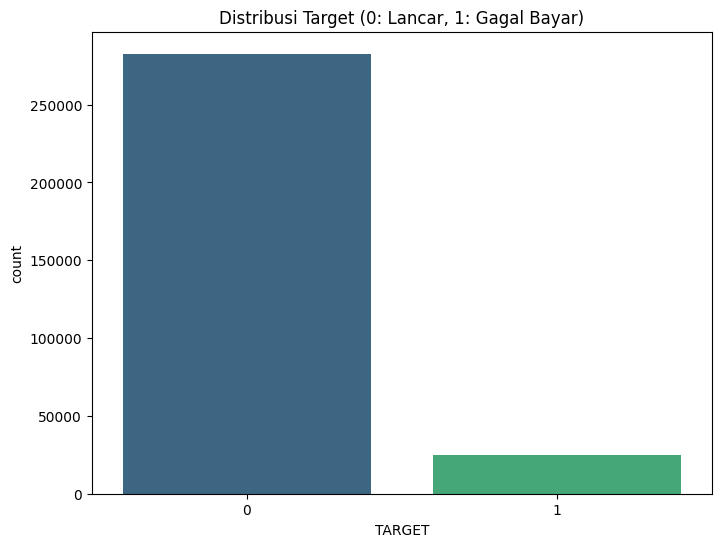

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribusi Target
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=app_train, palette='viridis',hue='TARGET', legend=False )
plt.title('Distribusi Target (0: Lancar, 1: Gagal Bayar)')
plt.show()

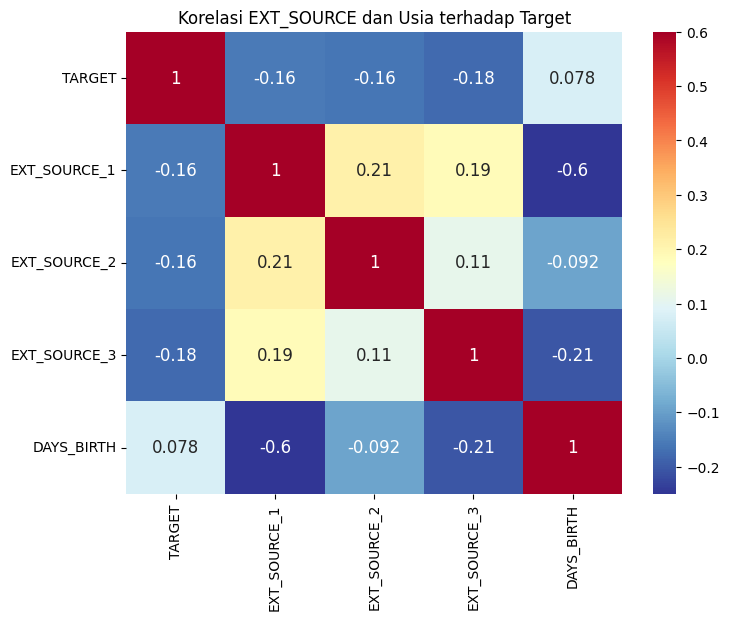

In [7]:
# Melihat korelasi fitur eksternal dengan Target
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, annot=True, cmap='RdYlBu_r', vmin=-0.25, annot_kws={"size": 12}, vmax=0.6)
plt.title('Korelasi EXT_SOURCE dan Usia terhadap Target')
plt.show()

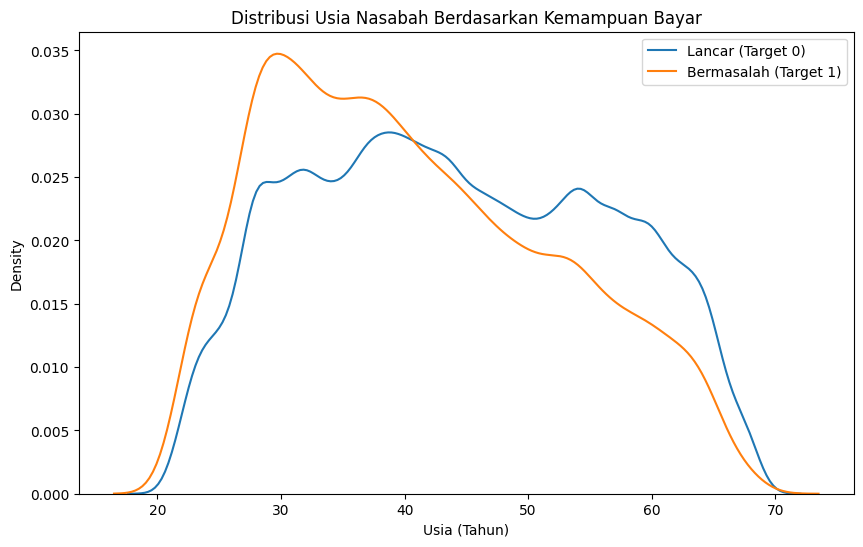

In [8]:
# Konversi hari ke tahun (nilai original negatif)
app_train['YEARS_BIRTH'] = abs(app_train['DAYS_BIRTH']) / 365

plt.figure(figsize=(10, 6))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_BIRTH'], label='Lancar (Target 0)')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_BIRTH'], label='Bermasalah (Target 1)')
plt.xlabel('Usia (Tahun)')
plt.ylabel('Density')
plt.title('Distribusi Usia Nasabah Berdasarkan Kemampuan Bayar')
plt.legend()
plt.show()

# Business Insight: Jika kurva "Bermasalah" lebih tinggi di usia muda (20-30 tahun), 
# artinya nasabah muda memiliki risiko kredit lebih tinggi. 
# Kebijakan kredit mungkin perlu diperketat untuk rentang usia tersebut.

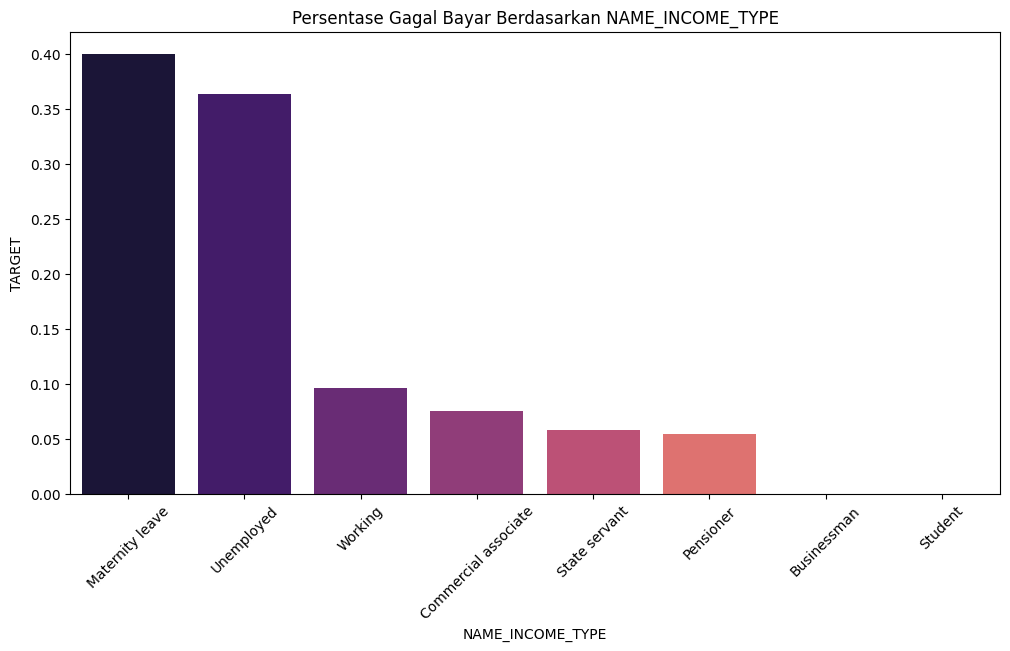

In [9]:
def plot_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Total Applications': temp.values})

    # Hitung persentase target=1 per kategori
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature, y='TARGET', data=cat_perc, palette='magma', hue=feature, 
        legend=False)
    plt.title(f'Persentase Gagal Bayar Berdasarkan {feature}')
    if label_rotation:
        plt.xticks(rotation=45)
    plt.show()

# Menjalankan fungsi untuk tipe pendapatan
plot_stats('NAME_INCOME_TYPE', label_rotation=True)

# Business Insight: Kategori seperti 'Laborers' atau 'Low-skill Laborers' 
# mungkin menunjukkan tingkat gagal bayar yang lebih tinggi dibanding 'State servant' atau 'Commercial associate'. 
# Ini membantu bank menentukan profil risiko sektor pekerjaan.

In [10]:
!pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Memisahkan fitur dan target dari hasil preprocessing sebelumnya
# Diasumsikan 'train_df' adalah dataframe hasil preprocessing
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

# Split data (80% Train, 20% Validasi)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data validasi: {X_valid.shape[0]}")

You should consider upgrading via the 'C:\Users\muhte\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Jumlah data training: 246008
Jumlah data validasi: 61503


In [11]:
import re

# Fungsi untuk membersihkan nama kolom
def clean_feature_names(df):
    # Mengganti karakter khusus dengan underscore
    new_cols = [re.sub(r'[^\w\s]', '_', col) for col in df.columns]
    # Mengganti spasi dengan underscore
    new_cols = [col.replace(' ', '_') for col in new_cols]
    df.columns = new_cols
    return df

# Terapkan pada dataset utama sebelum split
train_df = clean_feature_names(train_df)

# Jika Anda sudah melakukan split, bersihkan X_train dan X_valid
X_train.columns = [re.sub(r'[^\w\s]', '_', col).replace(' ', '_') for col in X_train.columns]
X_valid.columns = [re.sub(r'[^\w\s]', '_', col).replace(' ', '_') for col in X_valid.columns]

print("Nama kolom telah dibersihkan dari karakter khusus.")

# Membuat dataset untuk LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# Parameter dasar
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

# Training dengan Early Stopping
model = lgb.LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Nama kolom telah dibersihkan dari karakter khusus.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[351]	valid_0's auc: 0.774111


LGBMClassifier(learning_rate=0.05, metric='auc', n_estimators=1000,
               objective='binary', random_state=42, verbose=-1)


ROC-AUC Score: 0.7741

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.61      0.03      0.06      4965

    accuracy                           0.92     61503
   macro avg       0.77      0.52      0.51     61503
weighted avg       0.90      0.92      0.89     61503



<Figure size 800x600 with 0 Axes>

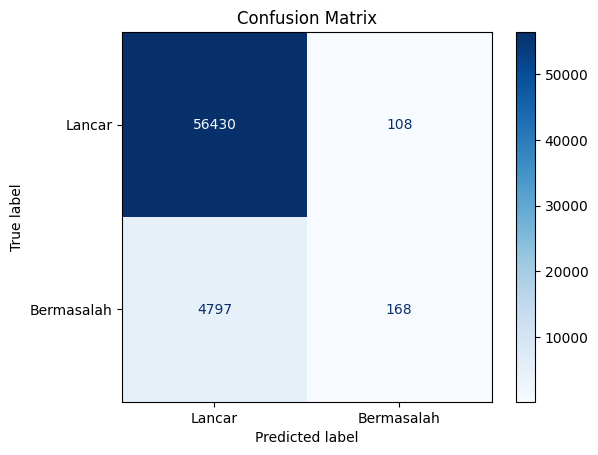

In [12]:
# Prediksi probabilitas
y_pred_proba = model.predict_proba(X_valid)[:, 1]
# Prediksi label (0 atau 1) dengan threshold default 0.5
y_pred = model.predict(X_valid)

# 1. Skor ROC-AUC
auc_score = roc_auc_score(y_valid, y_pred_proba)
print(f"\nROC-AUC Score: {auc_score:.4f}")

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lancar', 'Bermasalah'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

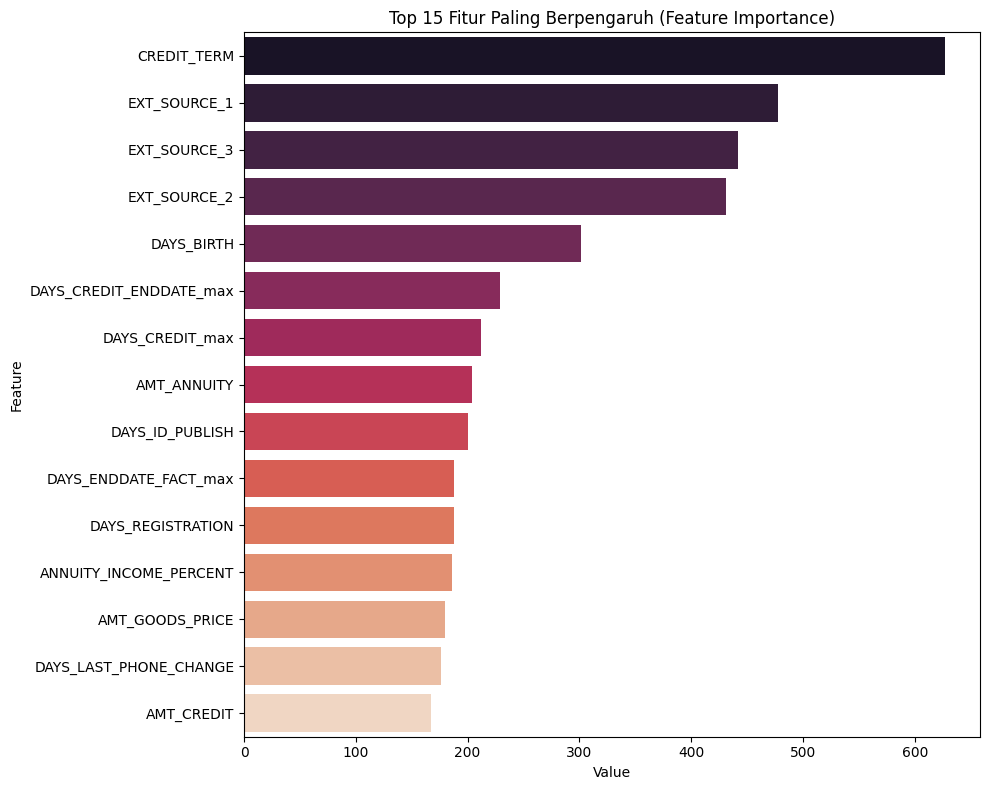

In [13]:
# Mendapatkan feature importance
feature_imp = pd.DataFrame({
    'Value': model.feature_importances_,
    'Feature': X.columns
}).sort_values(by="Value", ascending=False).head(15) # Ambil 15 teratas

plt.figure(figsize=(10, 8))
sns.barplot(
    x="Value", 
    y="Feature", 
    data=feature_imp, 
    palette='rocket',
    hue='Feature',
    legend=False
)
plt.title('Top 15 Fitur Paling Berpengaruh (Feature Importance)')
plt.tight_layout()
plt.show()

In [14]:
# Prediksi pada dataset test yang sudah di-preprocess
# test_features = ... (hasil preprocessing)
test_preds = model.predict_proba(test_features)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': test_preds
})
submission.to_csv('submission_result.csv', index=False)
print("Hasil prediksi telah disimpan ke submission_result.csv")

C:\Users\muhte\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hasil prediksi telah disimpan ke submission_result.csv


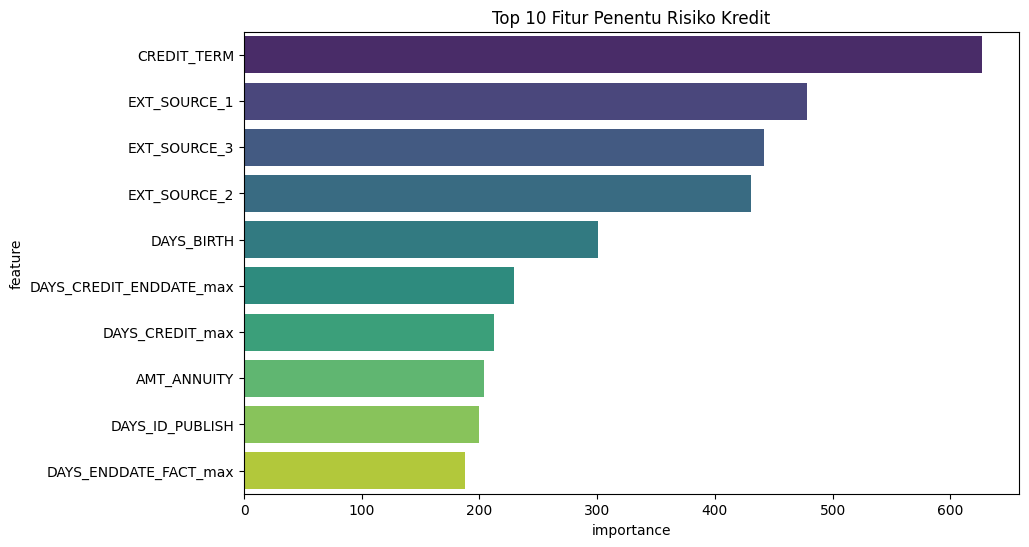

In [15]:
# Melihat 10 fitur paling berpengaruh
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), hue='feature', palette='viridis', legend=False)
plt.title('Top 10 Fitur Penentu Risiko Kredit')
plt.show()

In [16]:
# Pastikan test_df sudah melewati preprocessing dan pembersihan nama kolom yang sama
test_preds = model.predict_proba(test_df.drop(columns=['SK_ID_CURR']))[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': test_preds
})

submission.to_csv('hcc_submission.csv', index=False)
print("File prediksi hcc_submission.csv siap diunduh!")

File prediksi hcc_submission.csv siap diunduh!


Logistic Regression ROC-AUC Score: 0.7559

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.76     61503



<Figure size 800x600 with 0 Axes>

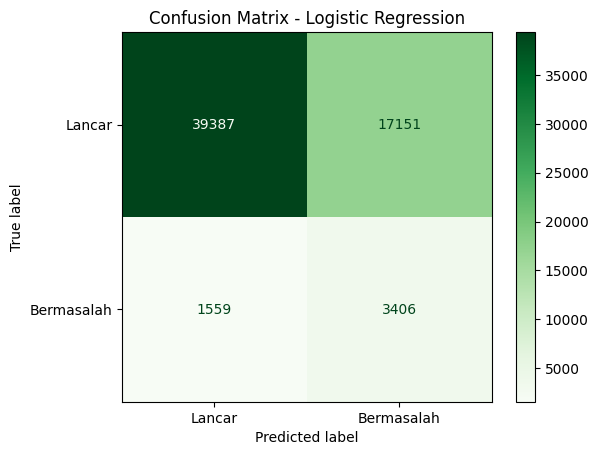

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Menyiapkan Data
# X: Fitur, y: Target
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

# Split data (80% Train, 20% Validasi)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Preprocessing Khusus Logistic Regression
# Mengisi nilai kosong dengan median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

# Standarisasi (Scaling) agar semua fitur memiliki range yang sama
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_valid_scaled = scaler.transform(X_valid_imputed)

# 3. Training Model
# Kita gunakan class_weight='balanced' karena data target tidak seimbang
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 4. Prediksi dan Evaluasi
y_pred_proba = lr_model.predict_proba(X_valid_scaled)[:, 1]
y_pred = lr_model.predict(X_valid_scaled)

# Skor AUC
auc_lr = roc_auc_score(y_valid, y_pred_proba)
print(f"Logistic Regression ROC-AUC Score: {auc_lr:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Lancar', 'Bermasalah'])
disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()